# <u>Projet 7: "Implémentez un modèle de scoring" - Modélisation<u>

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# <u>I. Prétraitement

## <u>I.1 Prétraitement des données

In [2]:
data = pd.read_csv('clean_data.csv')
data.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,Age,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,RATIO_ANNUITY_CREDIT,RATIO_INCOME_CREDIT,RATIO_INCOME_ANNUITY,RATIO_AGE_WORK_DAYS
0,0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,25.920548,637.0,3648.0,2120,1,0,1,0,Laborers,2,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,2.0,1134.0,0.060749,0.498036,8.198215,24.575098
1,2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,52.180822,225.0,4260.0,2531,1,1,1,0,Laborers,2,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.0,0.0,0.0,0.0,815.0,0.050000,0.500000,10.000000,4.311929
2,5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,46.413699,1588.0,4970.0,477,1,1,1,0,Laborers,2,16,0,0,0,0,0,0,Other,0.354225,0.621226,0.0,0.0,0.0,0.0,2536.0,0.056101,0.201837,3.597711,34.214037
3,6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,37.747945,3130.0,1213.0,619,1,0,1,0,Accountants,2,16,0,0,0,0,0,0,Business Entity Type 3,0.724000,0.492060,1.0,0.0,1.0,0.0,1562.0,0.026463,0.109564,4.140336,82.918421
4,7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.003122,51.643836,449.0,4597.0,2379,1,1,0,0,Managers,3,16,0,0,0,0,1,1,Other,0.714279,0.540654,2.0,0.0,2.0,0.0,1070.0,0.027500,0.235294,8.556150,8.694164


In [3]:
data = data.drop('Unnamed: 0', axis=1)

In [4]:
data.shape

(244852, 45)

In [5]:
data.dropna().shape

(244852, 45)

Il ne manque aucune valeur.

In [6]:
data.dtypes

SK_ID_CURR                       int64
TARGET                           int64
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
Age                            float64
DAYS_EMPLOYED                  float64
DAYS_REGISTRATION              float64
DAYS_ID_PUBLISH                  int64
FLAG_EMP_PHONE                   int64
FLAG_WORK_PHONE                  int64
FLAG_PHONE                       int64
FLAG_EMAIL                       int64
OCCUPATION_TYPE                 object
REGION_RATING_CLIENT_W_CI

In [7]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

nums_feats = make_column_selector(dtype_include=np.number)
categs_feats = make_column_selector(dtype_exclude=np.number)

numerical_pipeline_ss = make_pipeline(StandardScaler())
numerical_pipeline_mms = make_pipeline(MinMaxScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

prepro_ss  = make_column_transformer((numerical_pipeline_ss, nums_feats), (categorical_pipeline, categs_feats))
prepro_mms  = make_column_transformer((numerical_pipeline_mms, nums_feats), (categorical_pipeline, categs_feats))

In [8]:
X = data.drop('TARGET', axis=1)
Y = data['TARGET']

## <u>II.2 Métrique d'évaluation

Nous utiliserons l'aire sous la courbe ROC afin de déterminer l'efficacité de notre classifieur.

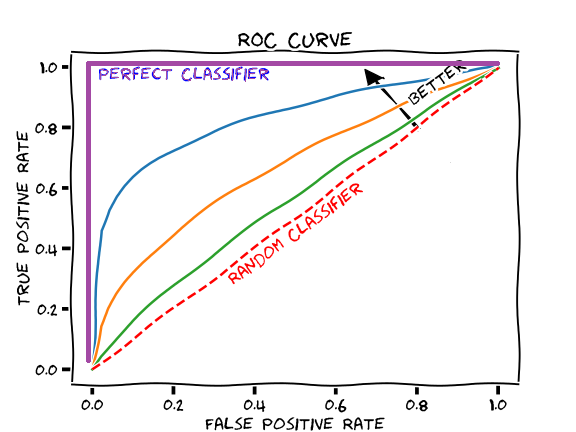

# <u>II. Baseline: Régression logistique

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)

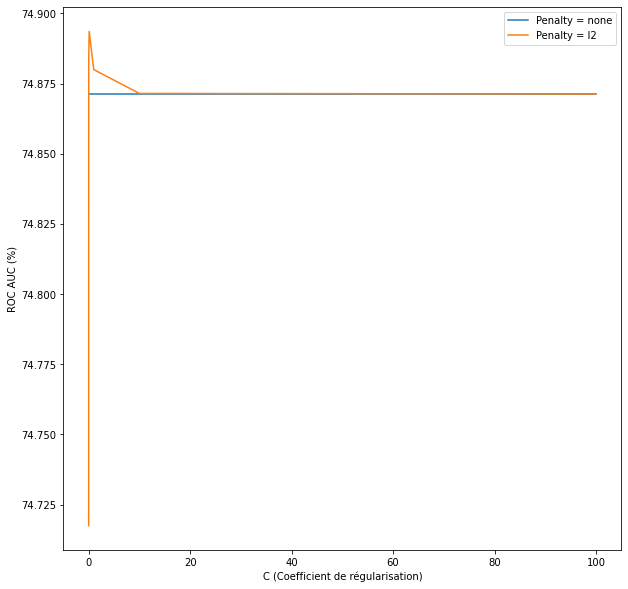

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

plt.figure(figsize=(10,10))

for penalty in ['none', 'l2']:
    
    log_reg = LogisticRegression(penalty=penalty)
    log_reg_model = make_pipeline(prepro_ss, log_reg)
    params = {'logisticregression__C': np.logspace(-3, 2, 6)}
    grid = GridSearchCV(log_reg_model, param_grid=params, cv=4, scoring = 'roc_auc')
    grid.fit(X_train, Y_train)
    
    x = list(grid.cv_results_['param_logisticregression__C'])
    scores = 100*grid.cv_results_['mean_test_score']
    plt.plot(x, scores, label= f'Penalty = {penalty}')

plt.ylabel('ROC AUC (%)')
plt.xlabel('C (Coefficient de régularisation)')
plt.legend()
plt.show()

In [12]:
log_reg = LogisticRegression(C=0.1)
log_reg_model = make_pipeline(prepro_ss, log_reg)
log_reg_model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A4BE61A850>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A4B6679850>)])),
                ('logisticregression', LogisticRegression(C=0.1))])

In [13]:
Y_predicted = log_reg_model.predict(X_test)
Y_predicted_prob = log_reg_model.predict_proba(X_test)[:, 1]

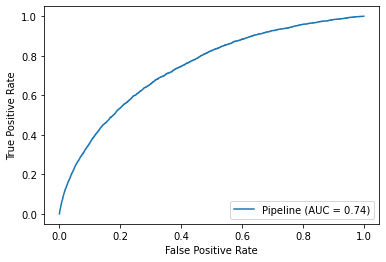

In [14]:
from sklearn import metrics 
metrics.plot_roc_curve(log_reg_model, X_test, Y_test)
plt.show()

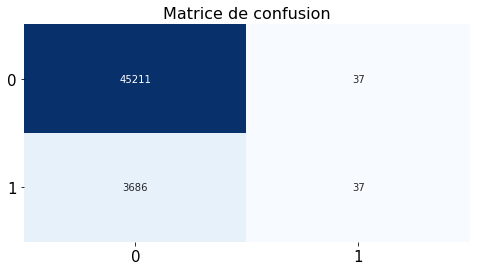

In [15]:
## Plot Matrice de confusion
    
cm = metrics.confusion_matrix(Y_test, Y_predicted)

plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title("Matrice de confusion", size=16)
plt.yticks(rotation=0, size=15)
plt.xticks(rotation=0, size=15)
plt.show()


In [24]:
def prediction_results(X_test, Y_test, model):
    
    Y_predicted = model.predict(X_test)
    Y_predicted_prob = model.predict_proba(X_test)[:, 1]

    metrics.plot_roc_curve(model, X_test, Y_test)
    plt.show()
    
    cm = metrics.confusion_matrix(Y_test, Y_predicted)

    plt.figure(figsize=(8,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    plt.title("Matrice de confusion", size=16)
    plt.yticks(rotation=0, size=15)
    plt.xticks(rotation=0, size=15)
    plt.show()
    
    print('Accuracy', metrics.accuracy_score(Y_test, Y_predicted))

On constate que moins d'1% des difficultés de paiements ont été détectées. Ce n'est pas un bon modèle.

Il faudrait essayer d'avoir autant d'individus ayant pour target 0 que d'individus ayant pour target 1.

In [16]:
data_2 = pd.concat([data[data['TARGET']==1],data[data['TARGET']==0].sample(20000)])

In [17]:
X = data_2.drop('TARGET', axis=1)
Y = data_2['TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
log_reg = LogisticRegression(C=0.1)
log_reg_model = make_pipeline(prepro_ss, log_reg)
log_reg_model.fit(X_train, Y_train)

Y_predicted = log_reg_model.predict(X_test)
Y_predicted_prob = log_reg_model.predict_proba(X_test)[:, 1]

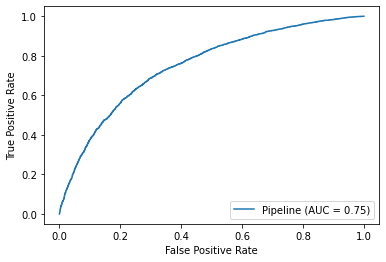

In [18]:
metrics.plot_roc_curve(log_reg_model, X_test, Y_test)
plt.show()

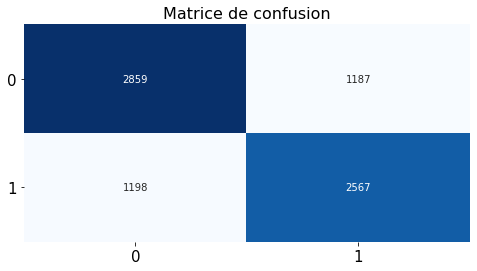

In [19]:
cm = metrics.confusion_matrix(Y_test, Y_predicted)

plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title("Matrice de confusion", size=16)
plt.yticks(rotation=0, size=15)
plt.xticks(rotation=0, size=15)
plt.show()

Le résultat semble bien plus concret. Essayons sur les données de test précédentes.

In [20]:
X = data.drop('TARGET', axis=1)
Y = data['TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
Y_predicted = log_reg_model.predict(X_test)
Y_predicted_prob = log_reg_model.predict_proba(X_test)[:, 1]

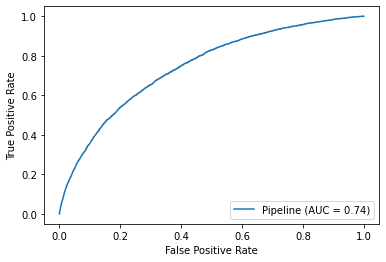

In [21]:
metrics.plot_roc_curve(log_reg_model, X_test, Y_test)
plt.show()

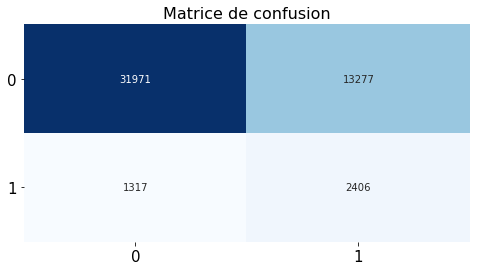

In [22]:
cm = metrics.confusion_matrix(Y_test, Y_predicted)

plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title("Matrice de confusion", size=16)
plt.yticks(rotation=0, size=15)
plt.xticks(rotation=0, size=15)
plt.show()

print()

Les prédictions semblent toujours assez correctes.

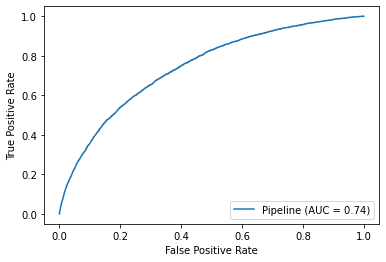

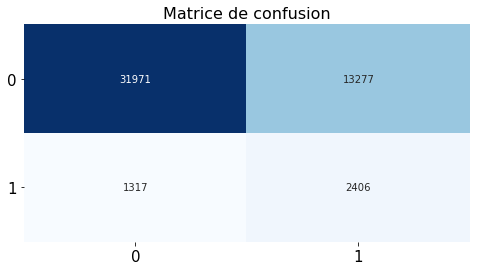

Accuracy 0.7019868902003227


In [25]:
prediction_results(X_test, Y_test, log_reg_model)

# <u>III. Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

X = data_2.drop('TARGET', axis=1)
Y = data_2['TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
rf = RandomForestClassifier(random_state=0)
rf_model = make_pipeline(prepro_ss, rf)
rf_model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A4BE61A850>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A4B6679850>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

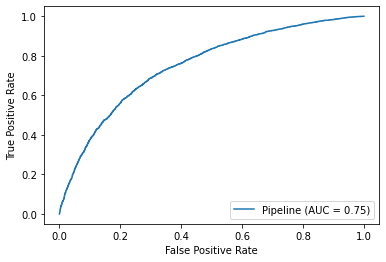

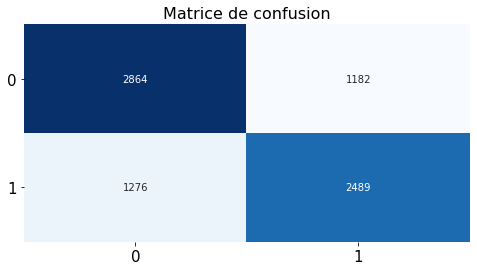

Accuracy 0.6853155805914736


In [27]:
prediction_results(X_test, Y_test, rf_model)

Le random Forest non-optimisé est un peu moins bon que la régression logistique.

In [32]:
def importance_features(pipeline_model):
    
    '''Retourne le dictionnaire des importances de chaque variables après entrainement d'un modèle
    basé sur des arbres de décision.
    Pour les variables trasformées par OneHotEncoding, les valeurs d'importances sont sommées et
    regroupées dans 'importance de la variable d'origine. Cette fonction vise principalement
    à automatiser ce processus complexe'''
    
    feats_importance = pipeline_model.steps[1][1].feature_importances_
    
    onehot_feats = rf_model.named_steps['columntransformer'].named_transformers_['pipeline-2']\
    .named_steps['onehotencoder'].get_feature_names()
    
    count_feats_dict = {}

    for i, col in enumerate(X_train.select_dtypes('object').columns):
        count_feats_dict[col]=0
        for feat in onehot_feats:
            if int(feat[1]) == i:
                count_feats_dict[col]+=1
    
    feats_importance_dict = {}

    for i, key in enumerate(list(X_train.select_dtypes(exclude='object').columns)):
        feats_importance_dict[key] = feats_importance[i]

    for key in list(count_feats_dict.keys()):
        feats_importance_dict[key] = 0

    n_num_feats = len(X_train.select_dtypes(exclude='object').columns)
    cat_number = 0
    n = list(count_feats_dict.values())[cat_number] + n_num_feats

    for i in range(n_num_feats, len(feats_importance)):
        if i < n + list(count_feats_dict.values())[cat_number]:
            key = list(count_feats_dict.keys())[cat_number]
            feats_importance_dict[key] += feats_importance[i]
        else:
            cat_number+=1
            n += list(count_feats_dict.values())[cat_number]
            key = list(count_feats_dict.keys())[cat_number]
            feats_importance_dict[key] += feats_importance[i]
            
    plt.figure(figsize=(10,20))
    pd.Series(feats_importance_dict).sort_values().plot(kind='barh', color = 'b')
    plt.show()

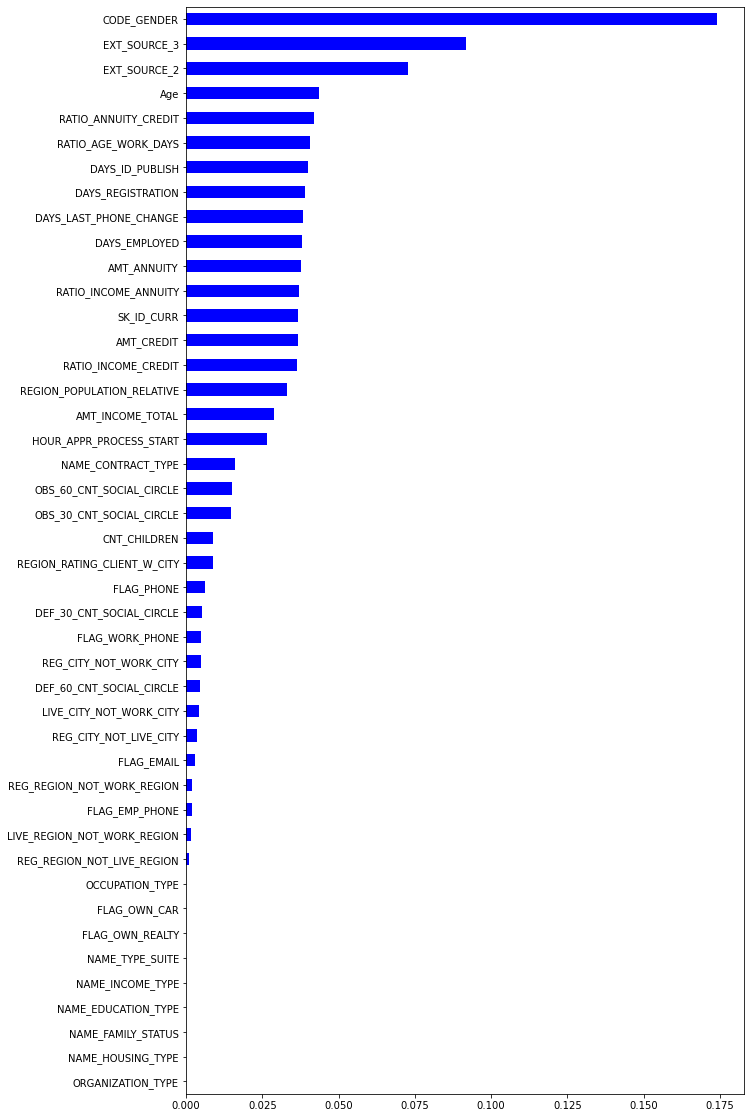

In [33]:
importance_features(rf_model)

**optimisation**

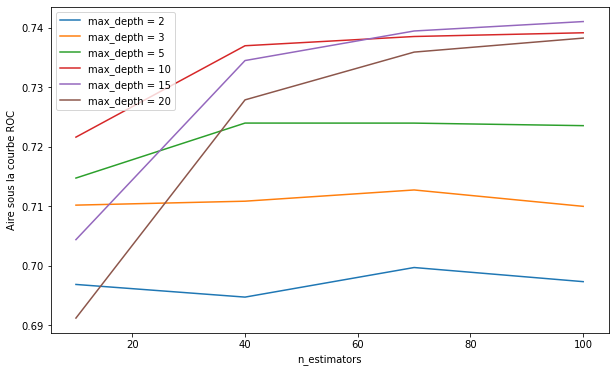

In [37]:
plt.figure(figsize=(10,6))

for k in [2, 3, 5, 10, 15, 20]:
    rf = RandomForestClassifier(random_state=0, max_depth=k)
    rf_model = make_pipeline(prepro_ss, rf)

    params = {'randomforestclassifier__n_estimators': np.arange(10, 130, 30)}
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
    grid = GridSearchCV(rf_model, param_grid=params, cv=4, scoring = 'roc_auc')
    grid.fit(X_train, Y_train)
    
    x = list(grid.cv_results_['param_randomforestclassifier__n_estimators'])
    scores = grid.cv_results_['mean_test_score']
    plt.plot(x, scores, label= f'max_depth = {k}')
        
plt.ylabel('Aire sous la courbe ROC')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

On choisira une max_depth de 15 et n_estimators au moins égal à 100

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] randomforestclassifier__min_samples_split=2 .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... randomforestclassifier__min_samples_split=2, total=   3.7s
[CV] randomforestclassifier__min_samples_split=2 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] ...... randomforestclassifier__min_samples_split=2, total=   3.5s
[CV] randomforestclassifier__min_samples_split=2 .....................
[CV] ...... randomforestclassifier__min_samples_split=2, total=   3.7s
[CV] randomforestclassifier__min_samples_split=2 .....................
[CV] ...... randomforestclassifier__min_samples_split=2, total=   3.9s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   3.7s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   3.5s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   3.7s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   3.9s
[CV] randomforestclassifier__min_samples_split=4 .....................
[CV] .

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  2.2min finished


Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] randomforestclassifier__min_samples_split=2 .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... randomforestclassifier__min_samples_split=2, total=   5.0s
[CV] randomforestclassifier__min_samples_split=2 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] ...... randomforestclassifier__min_samples_split=2, total=   4.6s
[CV] randomforestclassifier__min_samples_split=2 .....................
[CV] ...... randomforestclassifier__min_samples_split=2, total=   5.1s
[CV] randomforestclassifier__min_samples_split=2 .....................
[CV] ...... randomforestclassifier__min_samples_split=2, total=   5.1s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   4.9s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   4.6s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   4.8s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   5.1s
[CV] randomforestclassifier__min_samples_split=4 .....................
[CV] .

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  2.7min finished


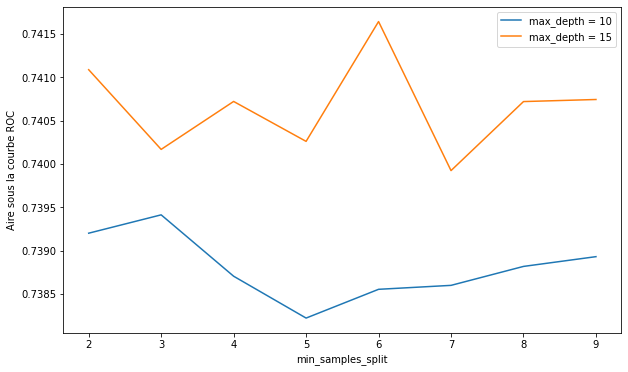

In [46]:
plt.figure(figsize=(10,6))

for k in [10, 15]:
    rf = RandomForestClassifier(random_state=0, max_depth=k)
    rf_model = make_pipeline(prepro_ss, rf)

    params = {'randomforestclassifier__min_samples_split': np.arange(2, 11, 2)}
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
    grid = GridSearchCV(rf_model, param_grid=params, cv=4, scoring = 'roc_auc')
    grid.fit(X_train, Y_train)
    
    x = list(grid.cv_results_['param_randomforestclassifier__min_samples_split'])
    scores = grid.cv_results_['mean_test_score']
    plt.plot(x, scores, label= f'max_depth = {k}')
        
plt.ylabel('Aire sous la courbe ROC')
plt.xlabel('min_samples_split')
plt.legend()
plt.show()

# <u>IV. Light Gradient Boosting

In [47]:
from lightgbm import LGBMClassifier

In [49]:
lgb = LGBMClassifier(random_state=0)
lgb_model = make_pipeline(prepro_ss, lgb)

In [50]:
lgb_model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A4BE61A850>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A4B6679850>)])),
                ('lgbmclassifier', LGBMClassifier(random_state=0))])

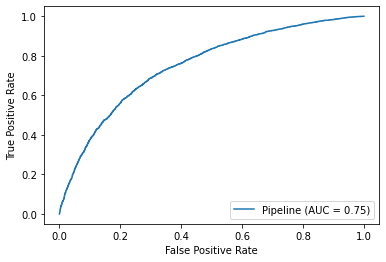

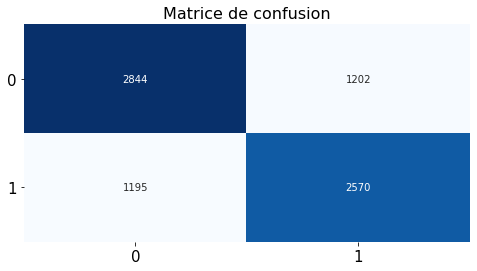

Accuracy 0.693125080015363


In [53]:
prediction_results(X_test, Y_test, lgb_model)

**Optimisation**

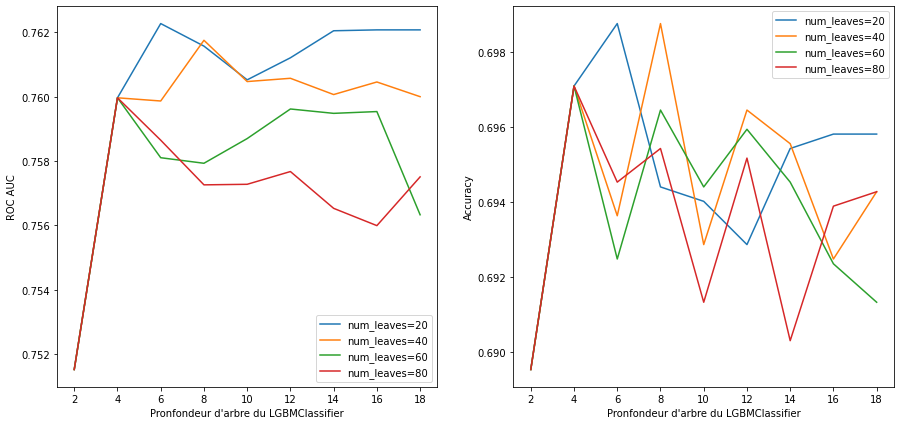

In [76]:
fig, ax = plt.subplots(1,2,figsize=(15, 7))

for i in np.arange(20, 100, 20):
    x, y1, y2 = [], [], []
    for k in np.arange(2, 20, 2):
        
        lgb = LGBMClassifier(random_state=0, max_depth=k, num_leaves=i)
        lgb_model = make_pipeline(prepro_ss, lgb)
        lgb_model.fit(X_train, Y_train)

        y_pred = lgb_model.predict(X_test)
        auc = metrics.roc_auc_score(Y_test, lgb_model.predict_proba(X_test)[:, 1])
        accuracy = metrics.accuracy_score(Y_test, y_pred)
        y1.append(auc)
        y2.append(accuracy)
        x.append(k)
    
    ax[0].plot(x, y1, label=f'num_leaves={i}')
    ax[1].plot(x, y2, label=f'num_leaves={i}')
    
    ax[0].set_xlabel("Pronfondeur d'arbre du LGBMClassifier")   
    ax[0].set_ylabel("ROC AUC")   
    ax[0].legend()
    ax[1].set_xlabel("Pronfondeur d'arbre du LGBMClassifier")   
    ax[1].set_ylabel("Accuracy")   
    ax[1].legend()
    
plt.show()

Nous choisirons max_depth=6 et num_leaves=20

In [77]:
lgb = LGBMClassifier(random_state=0, num_leaves=20, max_depth=6)
lgb_model = make_pipeline(prepro_ss, lgb)

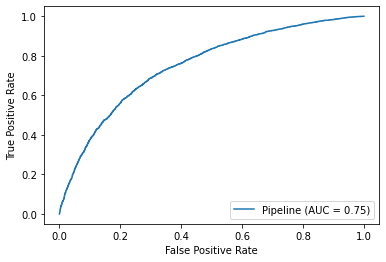

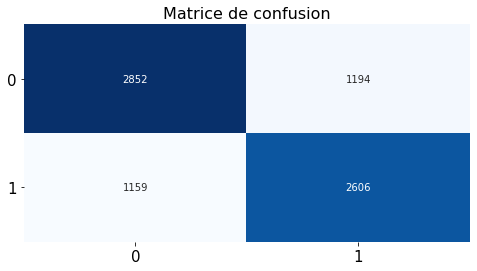

Accuracy 0.6987581615670209


In [78]:
lgb_model.fit(X_train, Y_train)
prediction_results(X_test, Y_test, lgb_model)

Nous avons finalement assez peu optimisé le modèle.

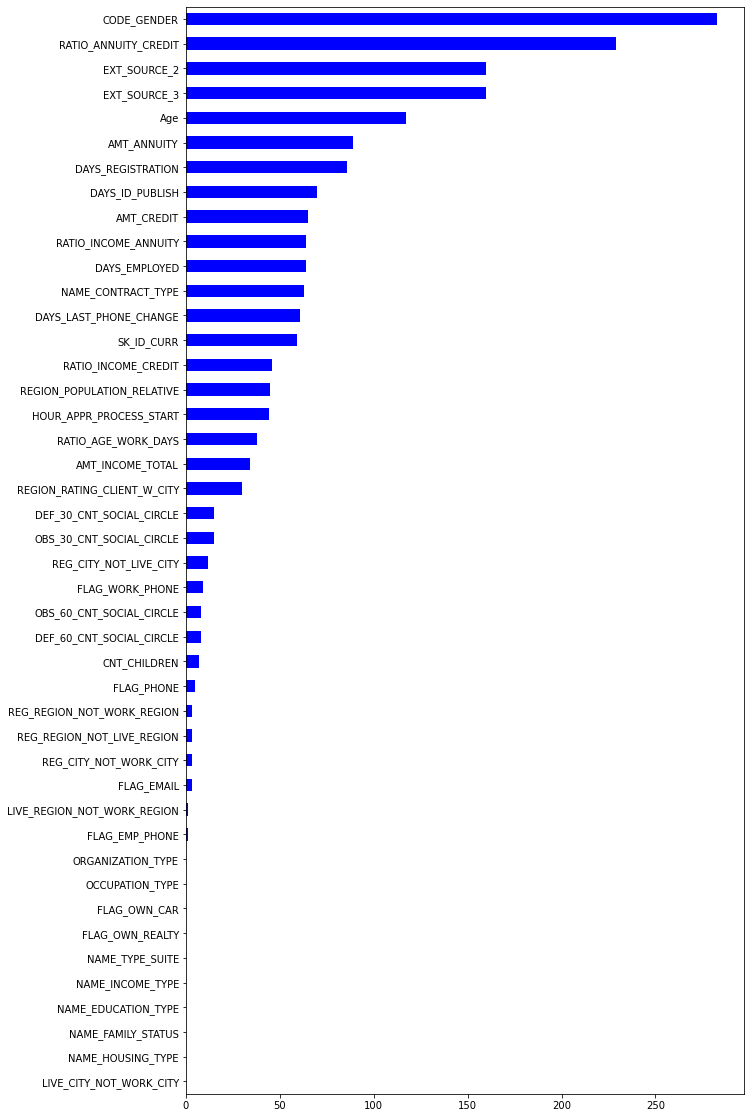

In [79]:
importance_features(lgb_model)